In [1]:
%matplotlib inline 
# 嵌入到notebook里面
from d2l import torch as d2l
import random
import torch

## 从零开始实现线性回归
### 加载输入数据

根据带有噪声的线性模型构造一个人造数据集。 我们使用线性模型参数w=[2,−3.4]⊤
、b=4.2
和噪声项ϵ
生成数据集及其标签：

y=Xw+b+ϵ

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) # num_examples表示n个样本，len(w)表示样本的列数，此处应该是2
    y = torch.matmul(X, w) + b
    print(y.shape)
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

torch.Size([1000])


In [3]:
print('features:', features[0], '\nlabel:',labels[0])

features: tensor([-1.5063, -0.0400]) 
label: tensor([1.3149])


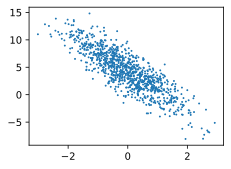

In [4]:
# 通过生成第二个特征features[:, 1]和labels的散点图， 可以直观观察到两者之间的线性关系。
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 读取数据集
回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。 由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数， 该函数能打乱数据集中的样本并以小批量方式获取数据。

在下面的代码中，我们定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)]) # 从i开始到 i+batch_size
        yield features[batch_indices], labels[batch_indices] # yield 表示 python的迭代器

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break
    


tensor([[ 0.2109,  0.9494],
        [ 0.6019,  0.4886],
        [ 0.3008, -1.6857],
        [-0.4337, -0.4406],
        [ 0.7413, -1.7244],
        [ 0.5633, -0.7080],
        [-1.0685,  0.1041],
        [-1.0118, -1.4380],
        [-0.3741, -0.4720],
        [-0.3012, -2.2124]]) 
 tensor([[ 1.3819],
        [ 3.7368],
        [10.5309],
        [ 4.8285],
        [11.5411],
        [ 7.7248],
        [ 1.7115],
        [ 7.0764],
        [ 5.0507],
        [11.1213]])


## 初始化模型参数
在我们开始用小批量随机梯度下降优化我们的模型参数之前， 我们需要先有一些参数。 在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0。

In [6]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 定义模型

In [7]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

## 定义损失函数
因为需要计算损失函数的梯度，所以我们应该先定义损失函数。

在实现中，我们需要将真实值y的形状转换为和预测值y_hat的形状相同。

In [8]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化算法
在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。 接下来，朝着减少损失的方向更新我们的参数。 

下面的函数实现小批量随机梯度下降更新。 该函数接受模型参数集合、学习速率和批量大小作为输入。每 一步更新的大小由学习速率lr决定。 

因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（batch_size） 来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。

In [9]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_() # 手动设置梯度=0

## 训练过程


In [10]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.041412
epoch 2, loss 0.000164
epoch 3, loss 0.000047


## 线性回归的简洁实现
在过去的几年里，出于对深度学习强烈的兴趣， 许多公司、学者和业余爱好者开发了各种成熟的开源框架。 这些框架可以自动化基于梯度的学习算法中重复性的工作。 在 3.2节中，我们只运用了： （1）通过张量来进行数据存储和线性代数； （2）通过自动微分来计算梯度。 实际上，由于数据迭代器、损失函数、优化器和神经网络层很常用， 现代深度学习库也为我们实现了这些组件。

### 生成数据集

In [11]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

ture_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### 读取数据集
我们可以调用框架中现有的API来读取数据。 我们将features和labels作为API的参数传递，并通过数据迭代器指定batch_size。 此外，布尔值is_train表示是否希望数据迭代器对象在每个迭代周期内打乱数据。

In [12]:
def load_array(data_arrays, batch_size, is_train=True): 
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [13]:
next(iter(data_iter))

[tensor([[ 2.4987,  0.0471],
         [ 1.1307,  1.1289],
         [-0.1213,  0.9243],
         [-1.9422, -0.1724],
         [ 2.9286,  0.7686],
         [-0.4159,  0.1223],
         [-0.0096,  1.1276],
         [-0.0100,  1.0527],
         [ 0.9639, -0.4990],
         [-0.8473,  1.2829]]),
 tensor([[ 9.0497],
         [ 2.6260],
         [ 0.8352],
         [ 0.9102],
         [ 7.4240],
         [ 2.9455],
         [ 0.3309],
         [ 0.6014],
         [ 7.8164],
         [-1.8599]])]

### 定义模型
当我们在 3.2节中实现线性回归时， 我们明确定义了模型参数变量，并编写了计算的代码，这样通过基本的线性代数运算得到输出。 但是，如果模型变得更加复杂，且当我们几乎每天都需要实现模型时，自然会想简化这个过程。 这种情况类似于为自己的博客从零开始编写网页。 做一两次是有益的，但如果每个新博客就需要工程师花一个月的时间重新开始编写网页，那并不高效。

对于标准深度学习模型，我们可以使用框架的预定义好的层。这使我们只需关注使用哪些层来构造模型，而不必关注层的实现细节。 我们首先定义一个模型变量net，它是一个Sequential类的实例。 Sequential类将多个层串联在一起。 当给定输入数据时，Sequential实例将数据传入到第一层， 然后将第一层的输出作为第二层的输入，以此类推。 在下面的例子中，我们的模型只包含一个层，因此实际上不需要Sequential。 但是由于以后几乎所有的模型都是多层的，在这里使用Sequential会让你熟悉“标准的流水线”。

回顾 图3.1.2中的单层网络架构， 这一单层被称为全连接层（fully-connected layer）， 因为它的每一个输入都通过矩阵-向量乘法得到它的每个输出。

In [15]:
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

### 定义损失函数
计算均方误差使用的是MSELoss类，也称为平方L2范数。 默认情况下，它返回所有样本损失的平均值。

In [16]:
loss = nn.MSELoss()

### 定义优化算法
小批量随机梯度下降算法是一种优化神经网络的标准工具， PyTorch在optim模块中实现了该算法的许多变种。 当我们实例化一个SGD实例时，我们要指定优化的参数 （可通过net.parameters()从我们的模型中获得）以及优化算法所需的超参数字典。 小批量随机梯度下降只需要设置lr值，这里设置为0.03。


In [17]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 训练
回顾一下：在每个迭代周期里，我们将完整遍历一次数据集（train_data）， 不停地从中获取一个小批量的输入和相应的标签。 对于每一个小批量，我们会进行以下步骤:

通过调用net(X)生成预测并计算损失l（前向传播）。

通过进行反向传播来计算梯度。

通过调用优化器来更新模型参数。


In [21]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000245
epoch 2, loss 0.000098
epoch 3, loss 0.000097


In [22]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 5.2130e-04, -5.9128e-05])
b的估计误差： tensor([-4.3869e-05])
